In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')


In [12]:
df = pd.read_csv('datasets/bio_only.csv')
df.head()

,ALT,AST,ALP,Bilirubin,Creatinine,Urea,Amylase,Lipase,LDH,Inflammation Localization
0,49.50,5.517262,138.44,1.17,0.68,14.42,82.61,62.99,280.00,unknown
1,14.60,29.000000,53.50,1.03,1.00,17.72,66.85,116.45,217.60,unknown
2,44.77,27.640000,98.84,1.20,0.88,8.77,48.44,46.78,239.53,unknown
3,23.22,25.520000,104.39,0.58,0.90,8.66,84.87,91.63,278.49,unknown
4,34.09,17.480000,126.15,0.66,1.30,14.96,78.84,41.50,280.00,unknown


In [13]:
df.info()
df.describe()
df['Inflammation Localization'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ALT                        2999 non-null   float64
 1   AST                        2999 non-null   float64
 2   ALP                        2999 non-null   float64
 3   Bilirubin                  2999 non-null   float64
 4   Creatinine                 2999 non-null   float64
 5   Urea                       2999 non-null   float64
 6   Amylase                    2999 non-null   float64
 7   Lipase                     2999 non-null   float64
 8   LDH                        2999 non-null   float64
 9   Inflammation Localization  2999 non-null   object 
dtypes: float64(9), object(1)
memory usage: 234.4+ KB


Inflammation Localization
unknown                 600
Почки                   600
Поджелудочная железа    600
Легкие                  600
Печень                  599
Name: count, dtype: int64

дисбаланс классов отсутствует

In [14]:
df.dropna(inplace=True)

# закодируем целевой столбец
le = LabelEncoder()
df['Inflammation Localization'] = le.fit_transform(df['Inflammation Localization'])

X = df.drop('Inflammation Localization', axis=1)
y = df['Inflammation Localization']

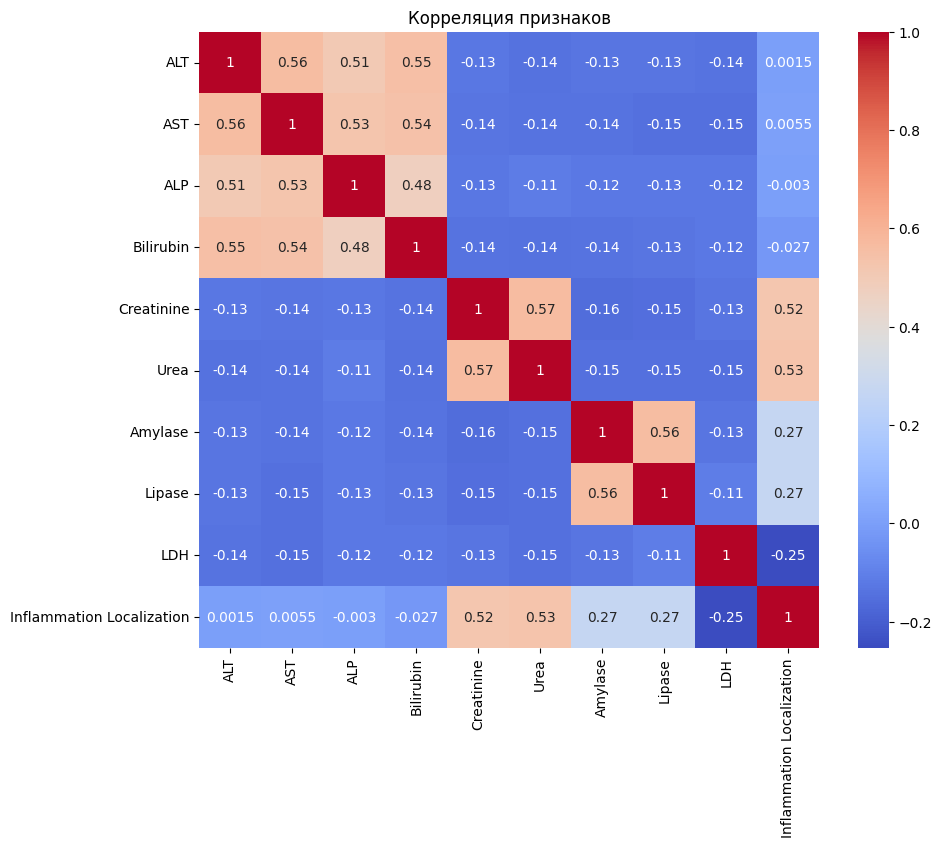

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'MLP Neural Network': MLPClassifier(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis()
}

In [18]:
results = []

for name, model in models.items():
    # для некоторых моделей скейлинг не нужен или даже вреден
    if name in ['Naive Bayes', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis']:
        pipe = Pipeline([('clf', model)])
    else:
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    
    results.append({
        'Model': name,
        'Accuracy': scores.mean(),
        'Std': scores.std()
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

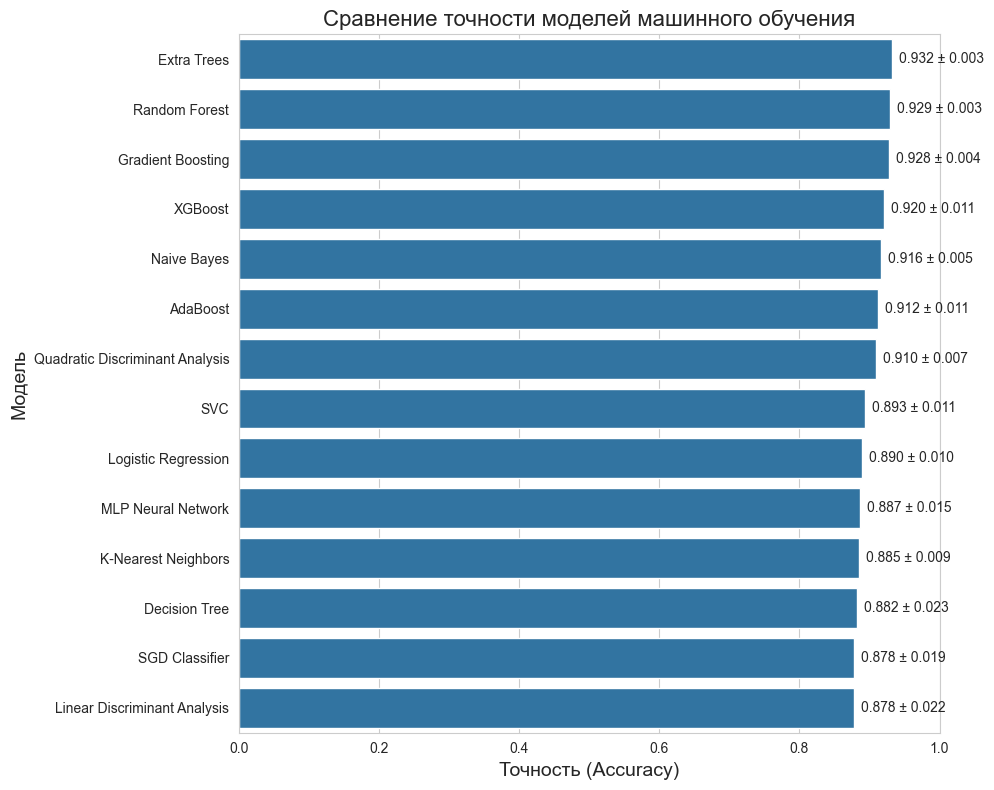

In [19]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
ax = sns.barplot(x='Accuracy', y='Model', data=results_df)

for i, (acc, std) in enumerate(zip(results_df['Accuracy'], results_df['Std'])):
    ax.text(acc + 0.01, i, f'{acc:.3f} ± {std:.3f}', va='center')

plt.title('Сравнение точности моделей машинного обучения', fontsize=16)
plt.xlabel('Точность (Accuracy)', fontsize=14)
plt.ylabel('Модель', fontsize=14)
plt.xlim(0, min(1.0, results_df['Accuracy'].max() + 0.15))
plt.tight_layout()
plt.show()

In [20]:
# пайплайн с StandardScaler (хотя для деревьев скейлинг не обязателен)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('etc', ExtraTreesClassifier(random_state=42))
])

param_grid = {
    'etc__n_estimators': [50, 100, 200],
    'etc__max_depth': [None, 10, 20, 30],
    'etc__min_samples_split': [2, 5, 10],
    'etc__min_samples_leaf': [1, 2, 4],
    'etc__max_features': ['sqrt', 'log2', None],
    'etc__bootstrap': [True, False],
    'etc__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('etc',
                                        ExtraTreesClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'etc__bootstrap': [True, False],
                         'etc__class_weight': [None, 'balanced'],
                         'etc__max_depth': [None, 10, 20, 30],
                         'etc__max_features': ['sqrt', 'log2', None],
                         'etc__min_samples_leaf': [1, 2, 4],
                         'etc__min_samples_split': [2, 5, 10],
                         'etc__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [21]:
best_etc = grid_search.best_estimator_

y_pred = best_etc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Лучшая модель Extra Trees:")
print(f"Точность (CV): {grid_search.best_score_:.4f}")
print(f"Точность (Test): {test_accuracy:.4f}")
print("\nЛучшие гиперпараметры:")
best_params = pd.DataFrame([grid_search.best_params_])
best_params

Лучшая модель Extra Trees:
Точность (CV): 0.9375
Точность (Test): 0.9333

Лучшие гиперпараметры:


,etc__bootstrap,etc__class_weight,etc__max_depth,etc__max_features,etc__min_samples_leaf,etc__min_samples_split,etc__n_estimators
0,False,balanced,30,None,4,10,100


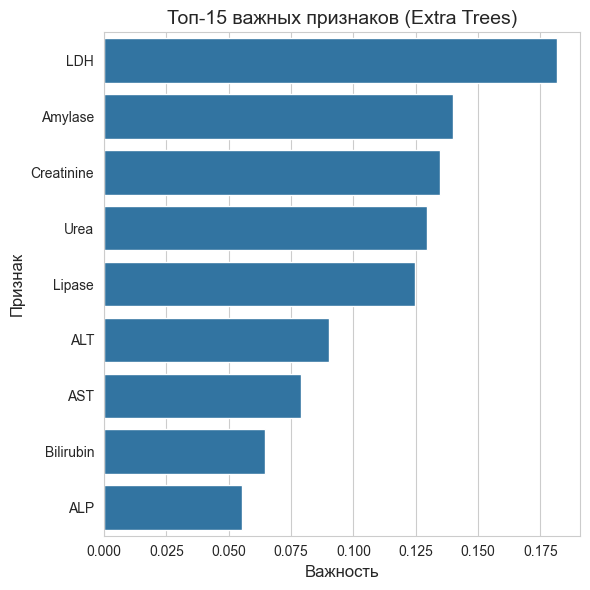

In [22]:
feature_importances = best_etc.named_steps['etc'].feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else range(len(feature_importances))

fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15))
plt.title('Топ-15 важных признаков (Extra Trees)', fontsize=14)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()

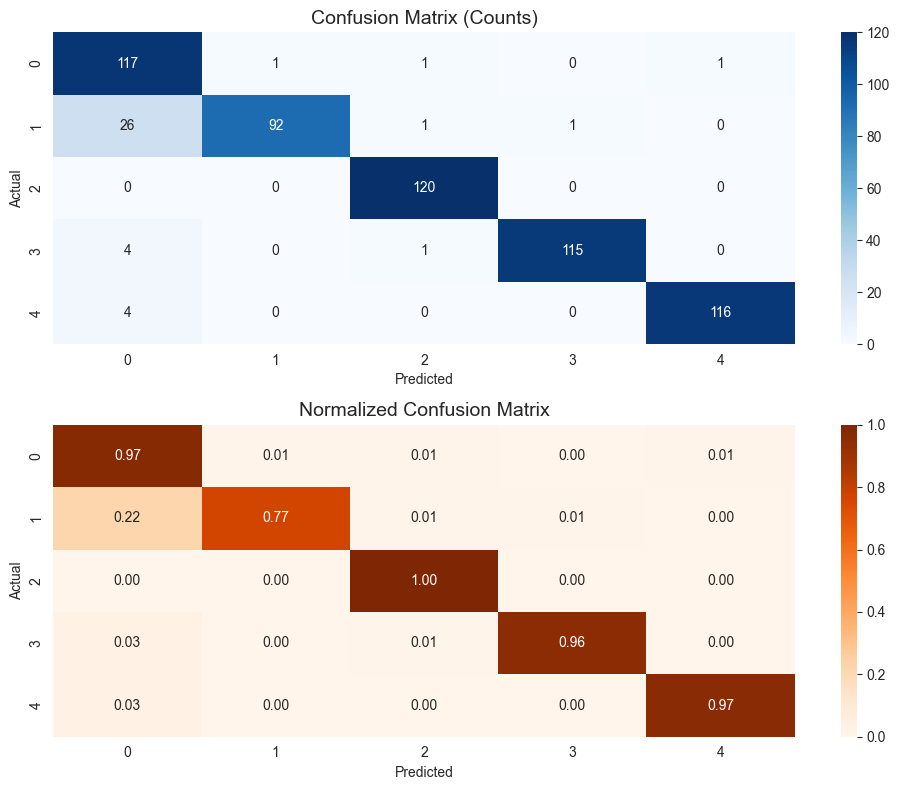

In [23]:
y_pred = best_etc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_etc.classes_,
            yticklabels=best_etc.classes_)
plt.title('Confusion Matrix (Counts)', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 1, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=best_etc.classes_,
            yticklabels=best_etc.classes_)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [24]:
from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(best_etc, method="sigmoid", cv=5)
calibrated.fit(X_train, y_train)
y_probs = calibrated.predict_proba(X_test)

In [25]:
def predict_with_threshold(y_probs, th):
    unknown_threshold = th
    is_unknown = y_probs[:, 0] >= unknown_threshold
    y_pred_adjusted = np.argmax(y_probs[:, 1:], axis=1) + 1  # +1 из-за unknown
    y_pred_adjusted[is_unknown] = 0  # если модель считает класс unknown — ставим 0
    return y_pred_adjusted

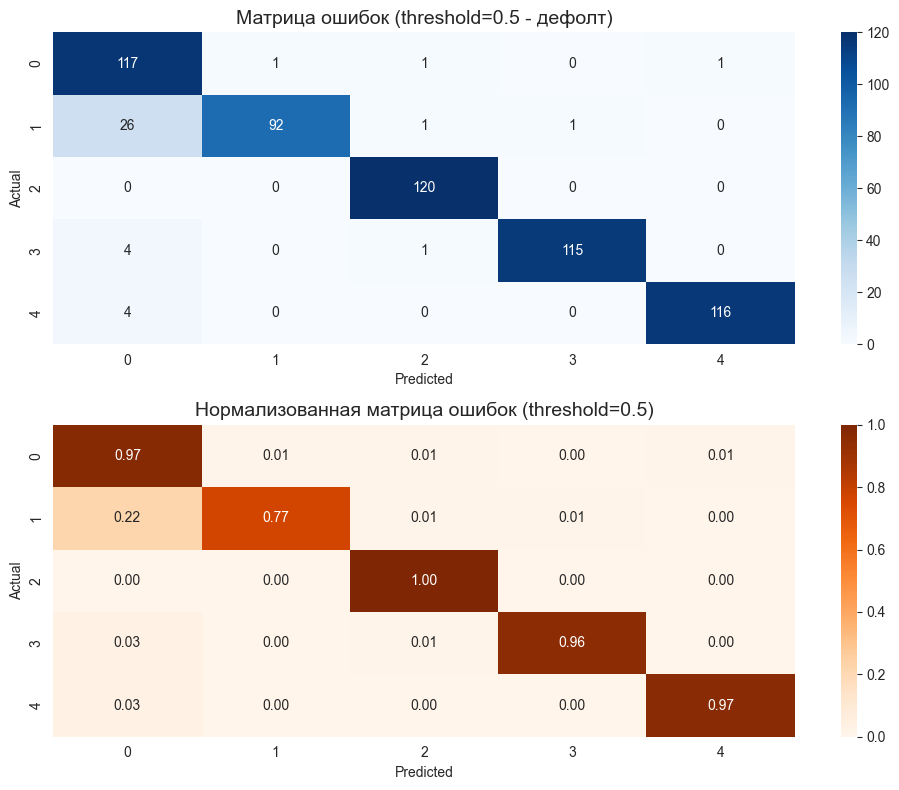

Threshold = 0.5 | F1 Macro: 0.9337 | F1 Weighted: 0.9337




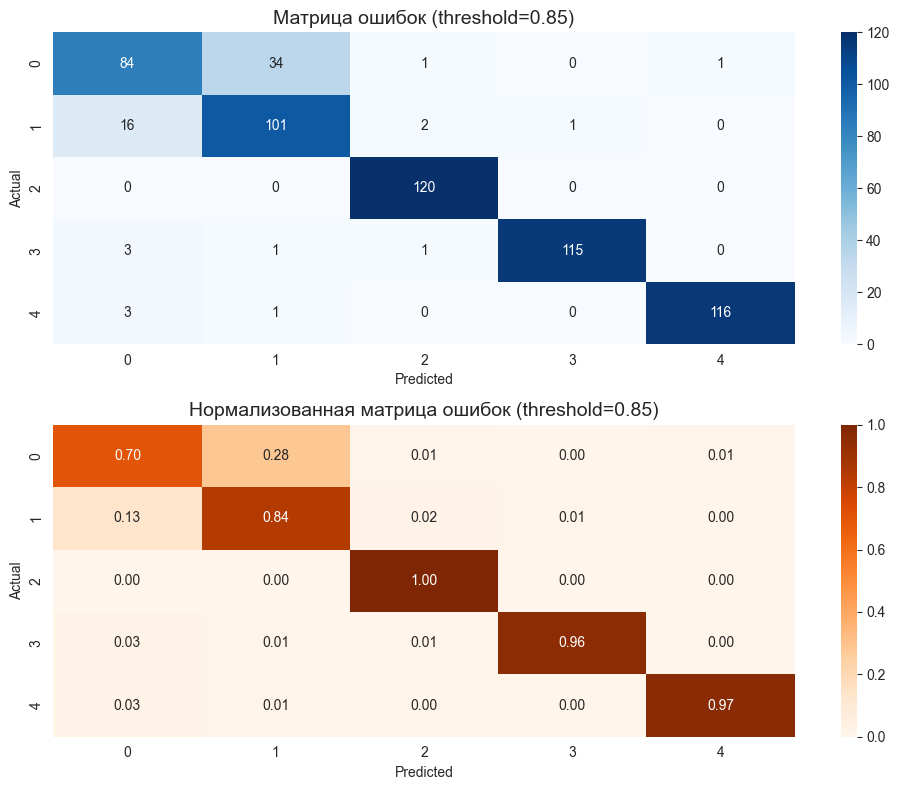

Threshold = 0.85 | F1 Macro: 0.8933 | F1 Weighted: 0.8933




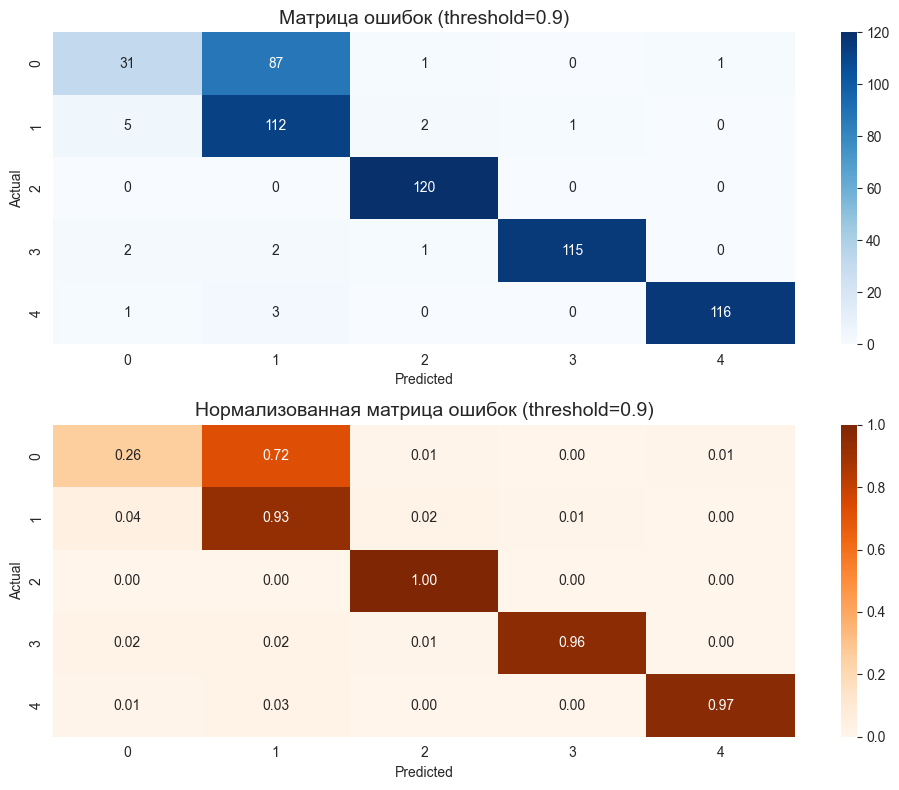

Threshold = 0.9 | F1 Macro: 0.8037 | F1 Weighted: 0.8037




In [31]:
thlds = [0.5, 0.85, 0.9]

for t in thlds:
    y_pred = predict_with_threshold(y_probs, t)
    cm = confusion_matrix(y_test, y_pred)

    # построение матриц
    plt.figure(figsize=(10, 8))

    # обычная матрица
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=best_etc.classes_,
                yticklabels=best_etc.classes_)
    if t == 0.5:
        plt.title(f'Матрица ошибок (threshold={t} - дефолт)', fontsize=14)
    else:
        plt.title(f'Матрица ошибок (threshold={t})', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # нормализованная матрица
    plt.subplot(2, 1, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
                xticklabels=best_etc.classes_,
                yticklabels=best_etc.classes_)
    plt.title(f'Нормализованная матрица ошибок (threshold={t})', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # f1-мера (macro и weighted)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"Threshold = {t} | F1 Macro: {f1_macro:.4f} | F1 Weighted: {f1_weighted:.4f}\n\n")

возникает вопрос: а что лучше?

- предсказывать, что **воспаление в легких**, когда **по факту локализация воспаления неизвестна**

или

- предсказывать, что **воспаление неизвестно где**, при этом **по факту оно в легких**

поскольку предсказание будет не таким строгим, то есть ответ модели - это не конкретное предсказание, а словарь формата {класс: вероятность}, то лучше ошибаться чаще в предсказании, что воспаление неизвестно где, при этом по факту оно в легких, чем наоборот, ведь так все равно будет видна высокая вероятность наличия воспаления в легких.

то есть threshhold = 0.5 является лучшим параметром - он же является стандартным, поэтому экспортируем и протестируем модель

In [27]:
joblib.dump(best_etc, 'extra_trees_model.joblib')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [28]:
loaded_model = joblib.load('extra_trees_model.joblib')
le = joblib.load('label_encoder.pkl')

test_sample = [[4.6, 59.0, 33.5, 5.03, 2.0, 37.72, 16.85, 126.45, 17.6]]

probabilities = loaded_model.predict_proba(test_sample)[0]

class_names = le.inverse_transform(loaded_model.classes_)
result = {
    name: round(float(prob) * 100, 2) 
    for name, prob in zip(class_names, probabilities)
}

print(result)

{'unknown': 1.57, 'Легкие': 1.13, 'Печень': 31.6, 'Поджелудочная железа': 1.13, 'Почки': 64.57}


In [29]:
for code, label in enumerate(le.classes_):
    print(f"{code} → {label}")

0 → unknown
1 → Легкие
2 → Печень
3 → Поджелудочная железа
4 → Почки
